In [1]:
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
import glob
import json
import os
import sys
import json
import os
import sys
import multiprocessing
pool = multiprocessing.Pool(multiprocessing.cpu_count())



In [7]:
df = pd.read_csv("ratings.csv")
df["video_name"] = df["video_name"].apply(
    lambda x: os.path.splitext(x.replace("['", "").replace("']", "").split("\\\\")[-1])[0]
)
d(df.head())

,rating,rating_type,timestamp,user_ID,video_ID,video_name
0,3,radio,2019-10-14 09:17:30 263829,1,0,BennuProRes4444.mov_1frame_crf_21_height_0320
1,4,radio,2019-10-14 09:17:40 502017,1,1,weapon8k-standard-60fps-12to1redcode_16x9_444....
2,2,radio,2019-10-14 09:17:53 471399,1,2,classroom.mkv_1frame_crf_18_height_0208
3,3,radio,2019-10-14 09:17:58 815831,1,3,NTIA_4K_Vignette_1_Violin-422p-8bit-60fps-4096...
4,4,radio,2019-10-14 09:18:04 565989,1,4,gooseberry.mkv_1frame_crf_08_height_0544


In [14]:
mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

d_wo = pd.DataFrame()
no_out = 0
no_sub = 0
# simple outlier "detection", better use the ITU-Rec XYZ
for userid, group in df.groupby(by="user_ID"):
    no_sub += 1
    comp = pd.merge(group, mos_per_videoname, left_on="video_name", right_on="video_name")
    # calc correlation
    correlation_user_to_mos = comp[["rating", "mos"]].corr(method="pearson")["mos"][0]
    if correlation_user_to_mos < 0.8:
        print(f"outlier user {userid}")
        no_out += 1
    else:
        d_wo = d_wo.append(group, ignore_index=True)

print(f"out of {no_sub} : {no_out} outlier detected")
    
df = d_wo
# calculate final mos values
mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

# calculate ci values
import scipy.stats as st

def confidence(x):
    x = x["rating"]
    y = st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
    return  y[1] - y[0]


ci = d_wo[["video_name", "rating"]].groupby(by="video_name").apply(confidence).reset_index()
ci = ci.rename(columns={0: "ci"})

d(ci.head())

mos_ci_per_videoname = pd.merge(mos_per_videoname, ci, left_on="video_name", right_on="video_name")
mos_ci_per_videoname = mos_ci_per_videoname.rename(columns={"video_name": "image_name"})
d(mos_ci_per_videoname.head())
mos_ci_per_videoname.to_csv("mos_ci.csv", index=False)

,video_name,mos
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857


out of 21 : 0 outlier detected


,video_name,mos
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857


,video_name,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0.435249


,image_name,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249


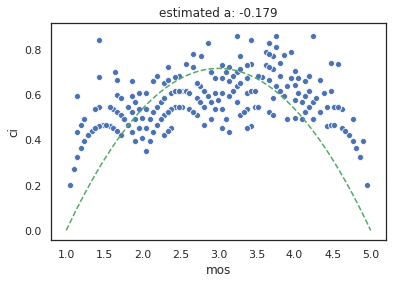

In [36]:
import seaborn as sns
sns.set_style("white")
# draw a SOS plot
# read: http://materials.dagstuhl.de/files/15/15022/15022.TobiasHo%C3%9Ffeld1.Preprint.pdf
# for a more detailed description of SOS plots

ax = sns.scatterplot(x="mos", y="ci", data=mos_ci_per_videoname)

#, with the y=(x-1)*(x-5)* a interpolated function 

x_data = mos_ci_per_videoname["mos"].values
y_data = mos_ci_per_videoname["ci"].replace(np.NaN, 0).values

from scipy.optimize import curve_fit

def fitting_function(x, a):
    return (x - 1) * (x - 5) * a

popt, pcov = curve_fit(fitting_function, x_data, y_data) 


x = np.linspace(1, 5, 100)
ax.plot(x, fitting_function(x, *popt), 'g--')
ax.set_title(f"estimated a: {popt[0].round(3)}")
os.makedirs("figures", exist_ok=True)
ax.get_figure().savefig("figures/sos.pdf", bbox="tight")
ax.get_figure().savefig("figures/sos.png", bbox="tight")

In [24]:
# create per user file
per_user = [] 
for i, g in df.groupby(by="video_name"):
    
    v = {
        "image_name": i,
        "mos": g["rating"].mean(),
        "ci": confidence(g)
    }
    for j, gg in g.groupby(by="user_ID"):
        user = "user" + str(j)
        v[user] = gg["rating"].values[0]
    per_user.append(v)

du = pd.DataFrame(per_user)
ucols = ["image_name"] + [x for x in du.columns if "user" in x] + ["mos", "ci"]
d(du[ucols].head())
du[ucols].to_csv("per_user.csv", index=False)

,image_name,user1,user2,user3,user4,user5,user6,user7,user8,user9,...,user14,user15,user16,user17,user18,user19,user20,user21,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,4,3,3,3,5,3,4,3,3,...,2,3,3,2,4,3,3,3,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,4,3,3,3,4,2,3,3,3,...,2,3,3,2,3,3,4,2,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,4,2,3,2,4,2,3,3,3,...,3,3,3,2,3,3,3,3,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,3,2,3,2,3,2,2,2,3,...,2,3,3,3,3,3,3,2,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,3,2,2,2,2,2,2,2,2,...,2,3,2,2,2,2,3,2,2.142857,0.435249


In [29]:
# meta data
du["crf"] = du["image_name"].apply(
    lambda x:
    int(x.split("_")[-3])
)
du["height"] = du["image_name"].apply(
    lambda x:
    int(x.split("_")[-1])
)
meta_cols = ["image_name", "crf", "height"]
d(du[meta_cols].head())
du[meta_cols].to_csv("meta.csv", index=False)

,image_name,crf,height
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3,864
1,BennuProRes4444.mov_1frame_crf_06_height_0592,6,592
2,BennuProRes4444.mov_1frame_crf_08_height_0448,8,448
3,BennuProRes4444.mov_1frame_crf_13_height_0304,13,304
4,BennuProRes4444.mov_1frame_crf_21_height_0320,21,320
